# The Orbital Surface Density Distribution and Multiplicity of M-Dwarfs

For this work, I redo my research project using an MCMC routine instead of the manual method I was using before. I use the same data, which was processed in a separate Jupyter Notebook. The results of this are saved in derived_data.py, which is imported towards the beginning of the code.  

## Introduction

M-Dwarfs are among the most numerous stars in the universe,
and many exist alongside at least one companion. Knowing the fraction of M-Dwarfs which have a stellar companion
will have important implications for star formation theories, inform
us about the emergence of planetary systems around low
mass stars, and allow for the modeling of both galactic and extragalactic
stellar populations. Fundamentally, the multiplicity fraction of a population of stars depends on the companion mass ratio distribution ($\psi$) and the orbital surface density distribution ($\phi$). The mass ratio, $q$, is defined as: $\frac{M_{secondary}}{M_{primary}}$ where, by definition, $M_{primary} \geq M_{secondary}$ so that $q \leq 1$. Furthermore, the semi-major axis, $a$, of a system serves as a measure of the separation between the primary and secondary stars. Using these two components, we calculate the multiplicity fraction as: \begin{equation}
    f = \int_{q_{min}}^{q_{max}}\psi dq * \int_{log_{10}a_{min}}^{log_{10}a_{max}}\phi dlog_{10}(a)\label {eq:1}
\end{equation} where $q_{min}, q_{max}, a_{min},$ and $a_{max}$ represent the lower and upper bounds for the regions of mass ratio and semi-major axis of interest. The first integral, the companion mass ratio distribution, is discussed in Reggiani \& Meyer (2013). The authors of this paper find that the formula: \begin{equation}
    \psi = q^{.25 \pm 0.29} \label{eq:2} 
\end{equation}describes this distribution for M-Dwarfs and other types of stars. __This work is focused on finding the functional form for $\phi$ in the first equation, the orbital surface density distribution.__ This is assumed to be a log-normal probability density function of the form: \begin{equation}
   \phi = A * \frac{e^{-(log_{10}(a) - log_{10}(\mu))^{2} / (2log_{10}(\sigma)^{2} )}}{log_{10}(\sigma)*\sqrt{2\pi}} \label{eq:3} \end{equation}
   with three parameters: amplitude ($A$), base-10 log of mean ($log_{10}\mu$), and base-10 log of standard deviation ($log_{10}\sigma$). __Once these parameters are determined, the first equation can be used to calculate the multiplicity of M-Dwarfs by integrating over specific ranges of mass ratio and semi-major axis.__ 
   
To this end, point estimates of the multiplicity fraction were compiled from five literature sources (one data set was split in to two, leading to six total estimates) which are at least 90% complete over specifics ranges of semi-major axis and are collectively at least 90% complete over the mass ratio range of 0.60 - 1.00. These multiplicity estimates would serve as the data in the model-fitting process below. The crux of this work is the MCMC routine which is used to fit the log-normal model to this data.

In summary, the goal of this work is to find the best-fit parameters to the oribital surface density distribution and to use this model, along with the mass ratio distribution from a related work, to calculate the frequency of M-Dwarf binary systems over a specific range of mass ratio and semi-major axis. 

## Initializations

Importing packages and libraries. 

Note: I made derived_data so that file must be downloaded alongside this notebook. 

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
rcParams['legend.frameon'] = False
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import derived_data as d # file with data derived during my data analyis process
import emcee
import corner
from scipy.stats import chi2
from astroML.plotting import scatter_contour
from scipy.optimize import curve_fit
from scipy import optimize, stats

First, I define the above equations as functions. I also specify the bounds of integration for the regions of q and a, which will be used throughout the following cells. These specific bounds come from that data I used. Each data set is representative over a specific range of semi-major axis; the smallest of these being 1e-10 AU and the largest being 10,000 AU. Every data set is representative over the range of mass ratio 0.60 - 1.00. 

Nu, the degrees of freedom, is the number of data sets (6) minus the number of fitted parameters (3) and is used the reduced chi-squared test.

In [2]:
def log_normal_pdf(x, mu, sigma):
    return (np.exp(-((x - mu)**2 / (2 * sigma**2)))) / (sigma * np.sqrt(2 * np.pi))

# orbital surface density distribution
def phi(mu, sigma, a_min, a_max):
    return integrate.quad(lambda a: log_normal_pdf(a, mu, sigma), a_min, a_max)[0]

# mass ratio distribution (R & M 2013)
def psi(q_min, q_max):
    return integrate.quad(lambda q: q**.25 , q_min, q_max)[0]

# f = A * psi * phi
def frequency(amp, q_min, q_max, mu, sigma, a_min, a_max):
    return amp * psi(q_min, q_max) * phi(mu, sigma, a_min, a_max)

# reduced chi-squared test
nu = 3 # number of data points (6) - number of fitted parameters (3)
def red_chi_sq(nu, model, data, error):
    return sum((1/nu) * np.power(np.subtract(data, model), 2) / np.power(error, 2))

q_min = 0.6
q_max = 1.0
a_min = 1e-10
a_max = 10000

Next, I initialize the log-likelihood, log-prior, and log-posterior that are used in my MCMC routine. The log-likelihood compares model frequencies (computed using the parameters drawn from the MCMC) to frequencies from the data using a chi-squared test. The model values are frequencies integrated over the ranges of semi-major axis which each data set (denoted by CC, Del, Jan, FM, WD_A, WD_B) is representative over and a common range of mass ratio. The data and error values come from the data analysis work I did some time ago. I use uniform priors with bounds informed by my previous work. 

In [3]:
def lnLikelihood(p): # p[] = A, mu, sigma
    # model frequencies
    f_CC = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
    f_Del = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
    f_Jan = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
    f_FM = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
    f_WD_A = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
    f_WD_B = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))
    
    models = [f_CC, f_Del, f_Jan, f_FM, f_WD_A, f_WD_B]
    data = [d.f_CC, d.f_Del, d.f_Jan, d.f_FM, d.f_WD_A, d.f_WD_B] # from data file
    errors = [d.e_CC, d.e_Del, d.e_Jan, d.e_FM, d.e_WD_A, d.e_WD_B] # from data file
    
    ll = np.nan_to_num(-0.5 * sum(np.power(np.subtract(data, models), 2) / np.power(errors, 2))) # chi-squared

    return ll

def lnPrior(p):
    if not (0 < p[0] < 2): # wide: 0 - 2
        return -np.inf
    if not (-1 < p[1] < 2): # wide: -2 - 5, narrow: -1 - 2
        return -np.inf
    if not (-1 < p[2] < 2): # wide: -2 - 4, narrow: -1 - 2
        return -np.inf        
    return 0.0

def lnPosterior(p):
    return lnPrior(p) + lnLikelihood(p)

## MCMC

Here I define and run the MCMC routine with 3 dimensions, 100 walkers, 5000 steps, and random (within the bounds of the prior) initial walker positions. I save the autocorrelation times, which will help in the analysis

In [4]:
ndim = 3
nwalkers = 100
nsteps = 5000
np.random.seed(0)

# random start positions
p0 = np.reshape([[np.random.uniform(0, 2, 1), np.random.uniform(-1, 2, 1), np.random.uniform(-1, 2, 1)] for i in range(nwalkers)], (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)
sampler.run_mcmc(p0, nsteps)

times = sampler.get_autocorr_time()


Next, I plot the entire flattened chains for each of the three parameters. These plots allow me to visually estimate what the burn-in values should be. I decide that a burn-in of 200 sufficiently gets rid of the wide variance in each of the flat chains. 

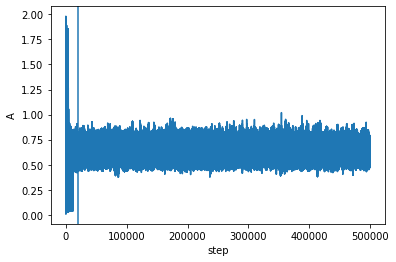

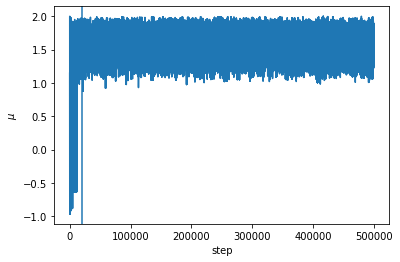

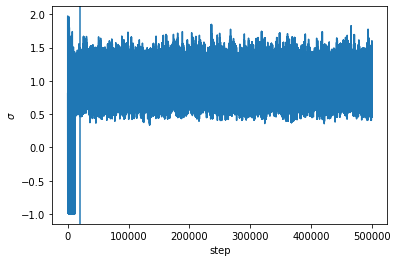

In [5]:
burns = 200 # looks right from graph

plt.plot(sampler.flatchain[:,0])
plt.axvline(100 * burns)
plt.xlabel("step")
plt.ylabel("A")
plt.show()
plt.plot(sampler.flatchain[:,1])
plt.axvline(100 * burns)
plt.xlabel("step")
plt.ylabel("$\mu$")
plt.show()
plt.plot(sampler.flatchain[:,2])
plt.axvline(100 * burns)
plt.xlabel("step")
plt.ylabel("$\sigma$")
plt.show()

Next, I cut out the burn in values for each of the parameters and I separate the chains of parameters into their own lists.

In [6]:
samples = sampler.chain[:, burns:, :].reshape((-1, 3)) # making it so that each parameter is its own column
A_vals = samples[:,0]
mu_vals = samples[:,1]
sigma_vals = samples[:,2]

I plot the corner plots from the MCMC process to depict the distributions of each parameter. 

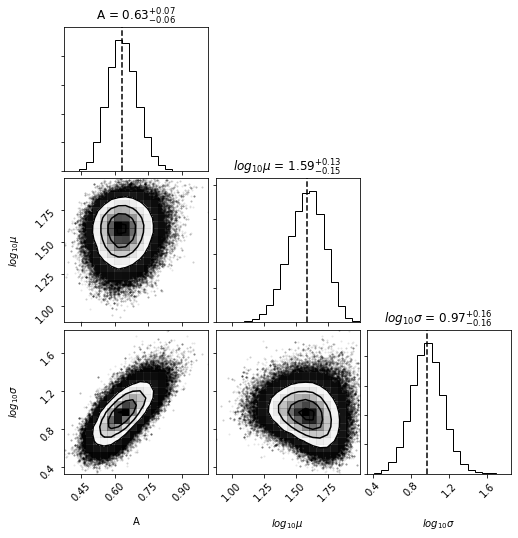

In [7]:
corner.corner(samples, labels=['A', '$log_{10}\mu$', '$log_{10}\sigma$'], quantiles=[0.5], show_titles=True)
plt.savefig("corner.jpeg", format = "jpeg", quality = 95)
plt.show()


I find it interesting that the mutual distribution of $\sigma$ and A seems to be correlated. I fit a line to this distribution using SciPy's optimize function to minimize a chi-squared value and then run Pearson's correlation test. I find that the line $\sigma = 1.75 * A - 0.15$ describes this, and a correlation coefficient of 0.70 suggests a strong linear correlation between the two parameters. I overplot the distribution with the line of best fit. 

best fit slope, intercept =  1.7524938980105214 -0.14535069589071456
correlation coefficient, p =  (0.698964650899943, 0.0)


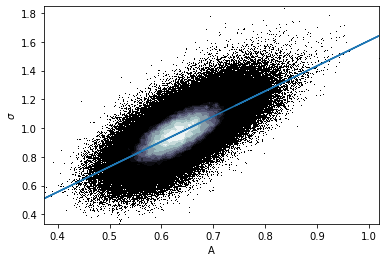

In [8]:
# chi-squared with y = mx + b built in
def lin_chi2(p):
    return np.sum((sigma_vals-p[1]-p[0]*A_vals)**2/(np.std(A_vals)**2 + np.std(sigma_vals)**2))

o = optimize.minimize(lin_chi2, [1, 0])
print("best fit slope, intercept = ", o.x[0], o.x[1])

print("correlation coefficient, p = ", stats.pearsonr(A_vals, sigma_vals))

scatter_contour(A_vals, sigma_vals, threshold=400, log_counts=True, histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='black'), contour_args=dict(cmap=plt.cm.bone))
# plt.plot(A_vals, popt[0] * A_vals + popt[1])
plt.plot(A_vals, o.x[0] * A_vals + o.x[1])
plt.xlabel("A")
plt.ylabel("$\sigma$")
plt.show()

I print out the best fit parameter values as the means of each of the parameter value lists. Then, I calculate the reduced chi-squared parameter value that is associated with this model's (with the best-fit parameters) fit to the data using the reduced chi-squared function from above. Next, I find with the probability of achieving a chi-squared value at least as extreme as this by integrating SciPy's implementation of the chi-squared PDF from the above chi-squared parameter to infinity. At the 0.05 significance level, I fail to reject the null hypothesis that the data comes from this model. Therefore, the model descibes the data.

In [9]:
# taking best fit to be mean of chains
best_A = np.mean(sampler.flatchain[:,0])
best_mu = np.mean(sampler.flatchain[:,1])
best_sigma = np.mean(sampler.flatchain[:,2])
print("Best fit A, log10-mu, log10-sigma =", best_A, best_mu, best_sigma)

# basically repeating one iteration of MCMC (but with best-fit parameters) to get a chi-squared value
f_CC = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
f_Del = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
f_Jan = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
f_FM = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
f_WD_A = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
f_WD_B = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))

models = [f_CC, f_Del, f_Jan, f_FM, f_WD_A, f_WD_B]
data = [d.f_CC, d.f_Del, d.f_Jan, d.f_FM, d.f_WD_A, d.f_WD_B]
errors = [d.e_CC, d.e_Del, d.e_Jan, d.e_FM, d.e_WD_A, d.e_WD_B]

p = integrate.quad(lambda x: chi2.pdf(x, nu) , nu * red_chi_sq(nu, models, data, errors), np.inf)[0]
print("red. chi-squared, p(X>x) =", red_chi_sq(nu, models, data, errors), p)

Best fit A, log10-mu, log10-sigma = 0.636918590120549 1.5768435192694514 0.9678538009187231
red. chi-squared, p(X>x) = 2.1436543483754895 0.09242527589929078


## Analysis of Results

I use the best-fit parameter values to calculate an associated frequency using the frequency function defined above. I find that the multiplicity fraction of M-Dwarfs is about 24%. 

In [10]:
q_min = 0.6
q_max = 1.0
a_min = 1e-10
a_max = 10000

best_f = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(a_min), np.log10(a_max))
print("Frequency from best-fit parameters =", best_f)

Frequency from best-fit parameters = 0.23898835260068235


The next step is to compute the error of the frequency. To do this, I first create a histogram of 1,000 randomly sampled frequency values by drawing 1,000 values for each of the three parameters and plugging these in to the frequency function. I then plot a histogram of this distribution. I use a top-hat kernal density estimation to find a continuous distribution which can describe this histogram. 

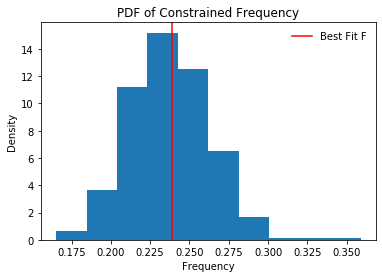

In [11]:
N = 1000
np.random.seed(0)

# putting parameters back into one array
stacked = np.stack((A_vals, mu_vals, sigma_vals)) 
# drawing N random values for each parameter
A_sample = np.random.choice(stacked[0], N)
mu_sample = np.random.choice(stacked[1], N)
sigma_sample = np.random.choice(stacked[2], N)

# calculating N frequencies to get distribution
freq_sample = []
for i, j, k in zip(A_sample, mu_sample, sigma_sample):
    freq_sample.append(frequency(i, q_min, q_max, j, k, np.log10(a_min), np.log10(a_max)))
    
plt.hist(freq_sample, density = True)  
plt.axvline(best_f, color = "red", label = "Best Fit F")

# fitting line to histogram distribution of frequencies
def kde_th(x, data, h):
    f = []
    n = len(data)
    a = b = 0
    u = [(x - i)/h for i in data]
    k = np.zeros(np.shape(u))
    for i in np.abs(u):
        for j in i:
            if j <= 1:
                k[a][b] = 0.5
            elif j > 1:
                k[a][b] = 0
            b += 1
        a += 1
        b = 0
    f = 1/(n * h) * sum(k)
    return(f)

x = np.linspace(min(freq_sample), max(freq_sample), N)
kde = kde_th(x, freq_sample, .01)

# plt.plot(x, kde)
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Density")
plt.title("PDF of Constrained Frequency")
plt.savefig("cfdist.jpeg", format = "jpeg", quality = 95)
plt.show()

I calculate the cumulative distribution function of the frequency values using a cumulatie integral, and the find the 68.3% and 90% confidence levels of the frequency distribution. In the end, I report the error on the frequency as the 90% confidence level. 

### This leads to a multiplicity fraction of M-Dwarfs of 0.239 +/- 0.04 
(over these specifics ranges of q and a).

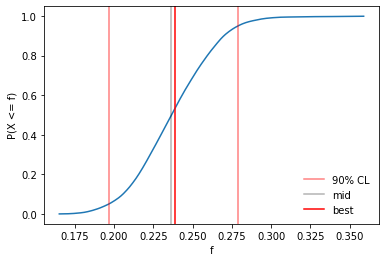

0.0024637848043961297
ANSWER: f = 0.23898835260068235 +/- 0.03998605807574873 0.04239377399759173


In [12]:
# getting cdf through cumulative integral
cdf = integrate.cumtrapz(kde, x, initial=0)

# calculating 2 confidence levels
level = [.9]
labs = ["90% CL"]
lower_bound = []
upper_bound = []
for i, l in zip(level, labs):

    lower = []
    upper = []
    mid = []
    upper_limit = .5 + i / 2
    lower_limit = .5 - i / 2
    for i in range(len(cdf)):
        lower.append(np.abs(cdf[i] - lower_limit))
        upper.append(np.abs(cdf[i] - upper_limit))
        mid.append(np.abs(cdf[i] - .50)) 

    lower_bound.append(x[np.where(lower == min(lower))[0][0]])
    upper_bound.append(x[np.where(upper == min(upper))[0][0]])
    mid = x[np.where(mid == min(mid))[0][0]]

    plt.plot(x, cdf)
    plt.xlabel("f")
    plt.ylabel("P(X <= f)")
    plt.axvline(lower_bound[-1], alpha = .5, color = "red", label = l)
    plt.axvline(mid, alpha = .3, color = "black", label = "mid")
    plt.axvline(upper_bound[-1], alpha = .5, color = "red")
    plt.axvline(best_f, color = "red", label = "best")
    plt.legend()
    plt.savefig("fdist.jpeg", format = "jpeg", quality = 95)
    plt.show()
    
print(abs(mid - best_f))
# print(best_f - lower_bound[0], best_f, best_f + upper_bound[0])
# print(best_f - lower_bound[1], best_f, best_f + upper_bound[1])
print("ANSWER: f =", best_f, "+/-", upper_bound[-1] - best_f, best_f - lower_bound[-1])

Next, I plot the orbital surface density distribution, which is a log-normal probability distribution function with the parameters that I found above.

C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


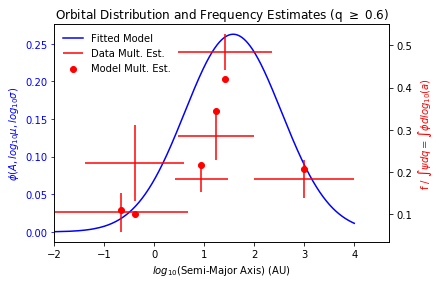

In [49]:
# creating space of log-semi-major axis
a = np.linspace(a_min, a_max, 1e6)
x = np.log10(a)
# orbital surface density distribution
pdf = best_A * log_normal_pdf(x, best_mu, best_sigma)

# simple PDF plot
# plt.plot(x, pdf)
# plt.ylabel('$\phi$')
# plt.xlabel("semi-major axis (AU)")
# plt.xlim(-2)
# plt.title("Orbital Surface Density Distribution, $q \geq 0.6$")
# plt.show()

# plotting for PDF + frequencies
fig, ax1 = plt.subplots()
ax1.plot(x, pdf, 'b-', label = "Fitted Model")
ax1.set_xlabel('$log_{10}$(Semi-Major Axis) (AU)')
ax1.set_ylabel('$\phi(A, log_{10}\mu , log_{10}\sigma$)', color='b')
# ax1.tick_params(axis='y', which='both', left=False, labelleft=False)
ax1.tick_params('y', colors='b')

dq = psi(q_min, q_max)

ax2 = ax1.twinx()
ax2.set_ylabel('f / $\int\psi dq = \int\phi dlog_{10}(a)$', color='r')

ax2.hlines(d.f_CC / dq, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC), color = "red", label = "Data Mult. Est.")
ax2.hlines(d.f_Del / dq, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del), color = "red")
ax2.hlines(d.f_Jan / dq, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan), color = "red")
ax2.hlines(d.f_FM / dq, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM), color = "red")
ax2.hlines(d.f_WD_A / dq, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A), color = "red")
ax2.hlines(d.f_WD_B / dq, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B), color = "red")

ax2.vlines(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), (d.f_CC / dq) - d.e_CC / dq, (d.f_CC / dq) + d.e_CC / dq, color = "red")
ax2.vlines(np.median([-2, np.log10(d.max_sep_limit_Del)]), (d.f_Del / dq) - d.e_Del / dq, (d.f_Del / dq) + d.e_Del / dq, color = "red")
ax2.vlines(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), (d.f_Jan / dq) - d.e_Jan / dq, (d.f_Jan / dq) + d.e_Jan / dq, color = "red")
ax2.vlines(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), (d.f_FM / dq) - d.e_FM / dq, (d.f_FM / dq) + d.e_FM / dq, color = "red")
ax2.vlines(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), (d.f_WD_A / dq) - d.e_WD_A / dq, (d.f_WD_A / dq) + d.e_WD_A / dq, color = "red")
ax2.vlines(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), (d.f_WD_B / dq) - d.e_WD_B / dq, (d.f_WD_B / dq) + d.e_WD_B / dq, color = "red")


ax2.scatter(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), f_CC / dq, color = "red", label = "Model Mult. Est.")
ax2.scatter(np.median([-2, np.log10(d.max_sep_limit_Del)]), f_Del / dq, color = "red")
ax2.scatter(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), f_Jan / dq, color = "red")
ax2.scatter(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), f_FM / dq, color = "red")
ax2.scatter(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), f_WD_A / dq, color = "red")
ax2.scatter(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), f_WD_B / dq, color = "red")

# ax2.annotate('CC', xy=(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), d.f_CC / dq))
# ax2.annotate('Del', xy=(np.median([np.log10(1e-2), np.log10(d.max_sep_limit_Del)]), d.f_Del / dq))
# ax2.annotate('Jan', xy=(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), d.f_Jan / dq))
# ax2.annotate('FM', xy=(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), d.f_FM / dq))
# ax2.annotate('WD_A', xy=(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), d.f_WD_A / dq))
# ax2.annotate('WD_B', xy=(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), d.f_WD_B / dq))

ax1.set_xlim(-2)
plt.title("Orbital Distribution and Frequency Estimates (q $\geq$ 0.6)")
# handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels)
ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
ax2.legend(bbox_to_anchor=(0, .93), loc='upper left', ncol=1)
plt.savefig("orbit_and_freqs.jpeg", format = "jpeg", quality = 95)
plt.show()


Finally, I summarize the frequency estimates compiled from the source data and those derived from my model. The red horizontal lines are the frequency estimates from the data, which are representative over range of semi-major axis covered by the widths of each line and have an errors denoted by the centered vertical lines. The blue horizontal lines are the frequency I calculate using my model of the same regions of semi-major axis. One can see that the blue lines do not always fall within error of the red lines, which indicates the middling accuracy of my model.

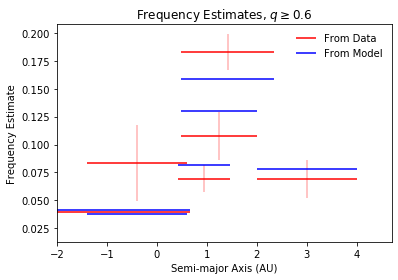

In [14]:
# frequencies from data drawn over range of semi-major axis value are representative over
plt.hlines(d.f_CC, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC), color = "red", label = "From Data")
plt.hlines(d.f_Del, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del), color = "red")
plt.hlines(d.f_Jan, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan), color = "red")
plt.hlines(d.f_FM, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM), color = "red")
plt.hlines(d.f_WD_A, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A), color = "red")
plt.hlines(d.f_WD_B, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B), color = "red")

# error on the frequenices from data file
plt.vlines(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), d.f_CC - d.e_CC, d.f_CC + d.e_CC, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del)]), d.f_Del - d.e_Del, d.f_Del + d.e_Del, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), d.f_Jan - d.e_Jan, d.f_Jan + d.e_Jan, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), d.f_FM - d.e_FM, d.f_FM + d.e_FM, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), d.f_WD_A - d.e_WD_A, d.f_WD_A + d.e_WD_A, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), d.f_WD_B - d.e_WD_B, d.f_WD_B + d.e_WD_B, color = "red", alpha = 0.3)

# frequencies found from frequency function with best fit parameters over ranges of semi-major axis ranges surveys cover
plt.hlines(f_CC, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC), color = "blue", label = "From Model")
plt.hlines(f_Del, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del), color = "blue")
plt.hlines(f_Jan, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan), color = "blue")
plt.hlines(f_FM, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM), color = "blue")
plt.hlines(f_WD_A, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A), color = "blue")
plt.hlines(f_WD_B, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B), color = "blue")

plt.xlabel("Semi-major Axis (AU)")
plt.ylabel("Frequency Estimate")
plt.title("Frequency Estimates, $q \geq 0.6$")
plt.legend()
plt.xlim(-2)
plt.savefig("freqs.jpeg", format = "jpeg", quality = 95)
plt.show()